In [1]:
import os
from os import path

os.environ["DEBUG"] = "fonts"

In [2]:
import random

import torch
from torch.utils.data import Subset
from transformers import AutoTokenizer, TrOCRProcessor

from lib.data_aug_v2 import build_data_aug
from lib.datasets import load_datasets, list_text_files, load_texts
from lib.tang_syn_config import preload_fonts, load_syn_config

MAX_LENGTH = 64

model_pth = 'models/tang-syn-5.0-online-epoch-1'

tokenizer = AutoTokenizer.from_pretrained(model_pth)
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# Load fonts
syn_config = load_syn_config()
fonts = preload_fonts(syn_config)

# Load texts
text_files = list_text_files()
texts = load_texts(text_files)

# Load datasets
train_dataset, eval_datasets = load_datasets(
    processor, tokenizer, fonts=fonts, texts=texts, syn_config=syn_config, debug=True)

pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
Fallback font cmaps loaded.
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame commu

100%|██████████| 3/3 [00:00<00:00, 5617.37it/s]


Loading text files...


100%|██████████| 7/7 [00:00<00:00, 819.22it/s]


7 text files loaded.
Initializing training dataset.
Initializing eval datasets.


100%|██████████| 1/1 [00:00<00:00, 762.46it/s]

Number of training examples: 36000000
Number of validation examples: 500 15


后我再回来吃饭。”
华子敬拿出行军手电筒，把电筒按亮，射出一道强烈的白光。他走到存松面前，
才是有用的。世上六岁的神通、十五岁的凡人、三十岁的饭桶多得很，更何况他并
不上学读书了。当然，他家欠的学费和应供给老师的粮食和油盐钱也没有着落了。
后头又跟着一只黄狗在吼叫，就笑着对他们说：“你们来得早啊。不要怕，狗是不
门讲对对子的书你可以拿去看看，然后问问你爸爸，慢慢就会了。”华宝玲热心地
他大大方方地交给梅斌科，问道：“这样对可以吗？”
华德贤笑着说：“原来你们是通一气的，存松不吃酒，你还护着他，你怕他喝
西，才发现这壶酒，这酒好像是特意为你接风的，你们两兄弟喝一杯吧。”
嫂，听我讲两句。现在是打日本


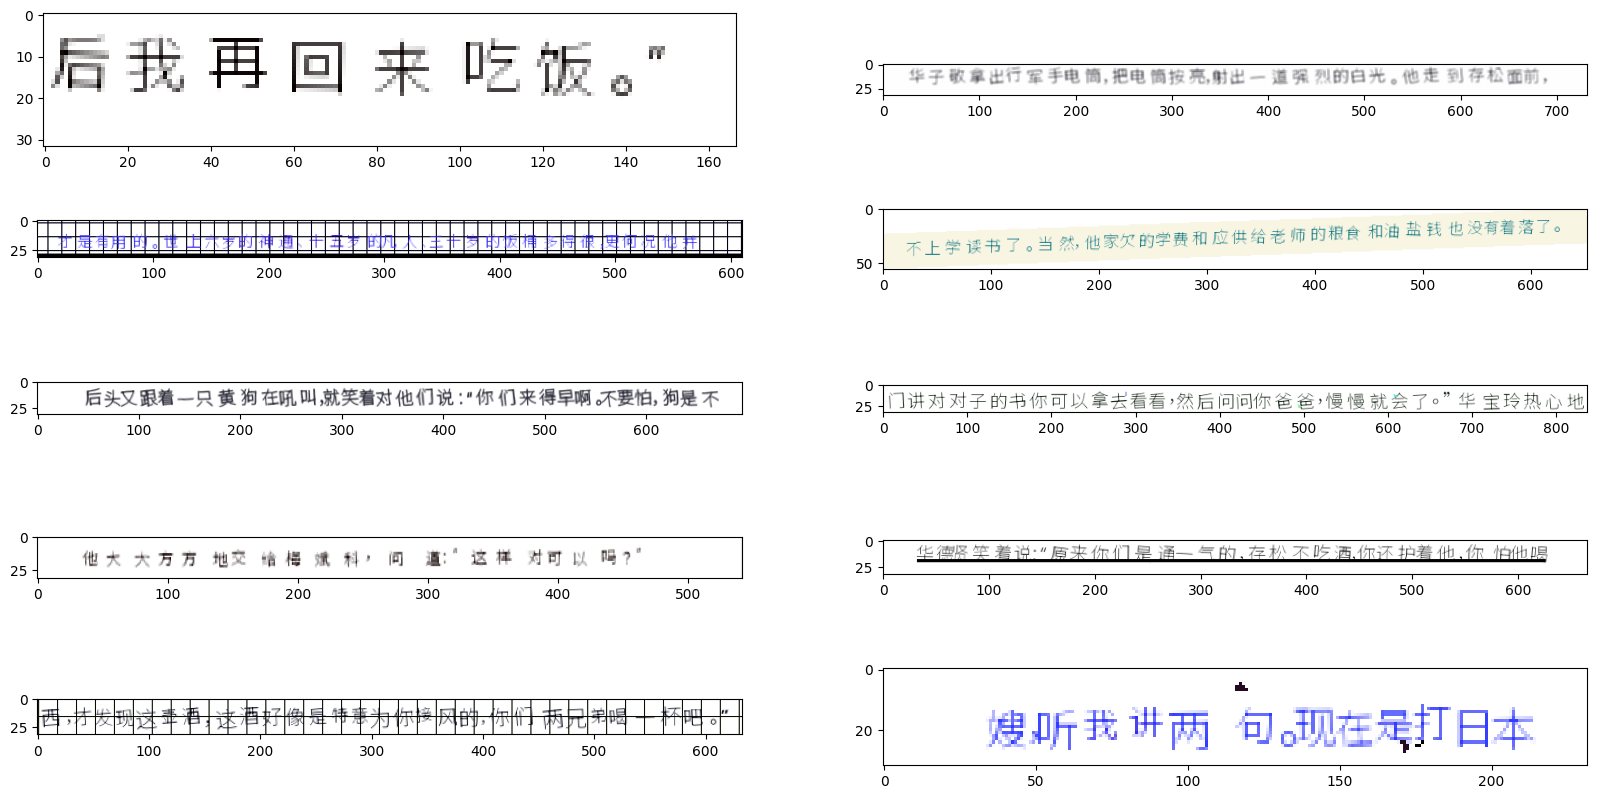

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))  # Set the figure size

length = len(train_dataset)

for i in range(10):

    random_index = random.randint(0, length - 1)
    res = train_dataset[random_index]

    plt.subplot(5, 2, i + 1)  # Create a subplot for each image
    plt.imshow(res[0])  # Display the image

    print(res[1])

plt.show()

In [4]:
torch.Tensor(tokenizer(res[1],
                       padding="max_length",
                       truncation=True,
                       max_length=64,
                       ).input_ids).dtype

torch.float32

In [5]:
tokenizer(res[1],
          padding="max_length",
          truncation=True,
          max_length=64,
          return_tensors="pt").input_ids.squeeze().dtype

torch.int64

In [6]:
processor(res[0], return_tensors="pt").pixel_values.squeeze().dtype

torch.float32

In [7]:
from tqdm import tqdm

for i in tqdm(range(1000)):
    random_index = random.randint(0, length - 1)
    res = train_dataset[random_index]

100%|██████████| 1000/1000 [00:10<00:00, 93.62it/s]
